# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
sns.set_style('ticks')

import itertools
%matplotlib inline

# Loading data 


In [2]:
df = pd.read_csv("breast-cancer-wisconsin.data",header = None )

df.columns = ['sample', 'thickness', 'size', 'shape', 'adhesion', 
              'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status']

# Checking the data 

In [3]:
df.head(3)

,sample,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2


In [4]:
#checking datatype of each features in data set
df.dtypes

sample         int64
thickness      int64
size           int64
shape          int64
adhesion       int64
epithelial     int64
nuclei        object
chromatin      int64
nucleoli       int64
mitoses        int64
status         int64
dtype: object

We can see that the data type of the feauture 'nuclei' is objectical not numerical. So the loading data step has some issue we need to fix it before further steps.

In [5]:
df.nuclei.unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'], dtype=object)

So the issue is that the NaN in nulei is in form of '?' and did not convert correctly when we load data.

In [6]:
df.nuclei = pd.to_numeric(df.nuclei, errors ='coerce')

In [7]:
#I want add the label columns to show the type of status for visulation only, no need for modeling
def set_status_class(x):
    return ['benign' if (y == 2) else 'malignant' for y in x]

df['label'] = set_status_class(df['status'])

In [8]:
# checking the NaN values in data set
df.isnull().any()

sample        False
thickness     False
size          False
shape         False
adhesion      False
epithelial    False
nuclei         True
chromatin     False
nucleoli      False
mitoses       False
status        False
label         False
dtype: bool

In [9]:
# replace the NaN values with mean value for each features and drop the "sample". It is not useful for modeling 
df= df.fillna(df.mean())
df = df.drop(['sample'], axis =1)

# Get the list of columns in dataframe, we can use it for normalization later
col_list = df.columns

In [10]:
# Quick look on statistic information from data 
df.describe()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.601852,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


# Normalization data 

In [11]:
# I will do normalization on the numerical columns from the data frame 
# Using the MinMax Scaler

norm_list = ['thickness', 'size', 'shape', 'adhesion', 'epithelial',
       'nuclei', 'chromatin', 'nucleoli', 'mitoses','status']

minmax = MinMaxScaler()
df[norm_list] = minmax.fit_transform(df[norm_list])

In [12]:
print("Dataframe shape: ", df.shape)
df.head(3)


Dataframe shape:  (699, 11)


,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status,label
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0,0.0,benign
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0,0.0,benign
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0,0.0,benign


# Visualization Data 

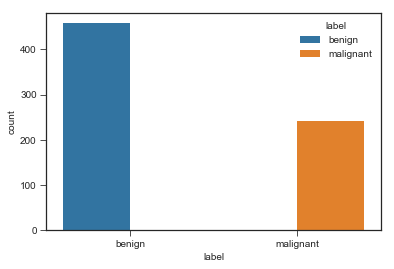

In [54]:
#checking the number of patient in two classes
sns.countplot(x = "label", hue ="label", data =df)

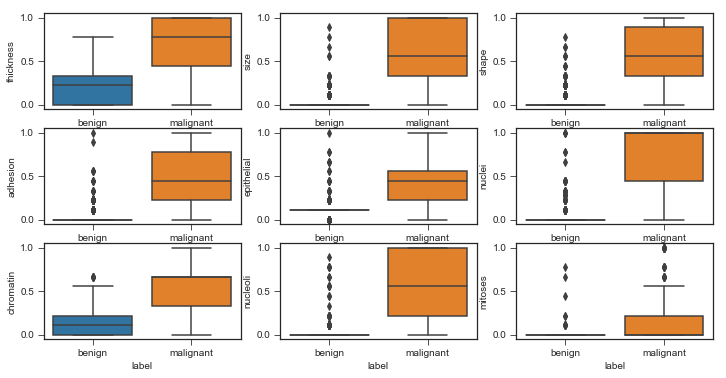

In [56]:
# The box plots for ALL numerical columns

norm_list = ['thickness', 'size', 'shape', 'adhesion', 'epithelial',
       'nuclei', 'chromatin', 'nucleoli', 'mitoses']

fig,axes = plt.subplots(3,3, figsize = (12,6))
for i, t in enumerate(norm_list):
    sns.boxplot(y =t, x = "label", data= df, ax = axes[i//3, i%3]) 
    
fig.savefig("boxplot_numerical.pdf")    

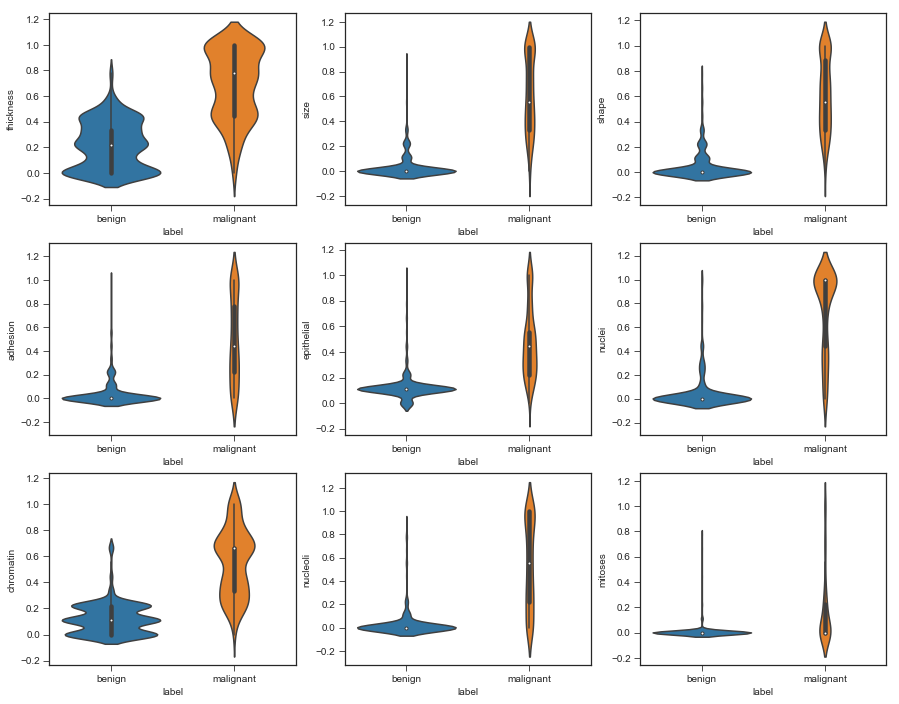

In [57]:
# try with violin plots:
fig,axes = plt.subplots(3,3, figsize = (15,12))
for i, t in enumerate(norm_list):
    sns.violinplot(y =t, x = "label", data= df, ax = axes[i//3, i%3]) 
    
fig.savefig("violin_numerical.pdf")    

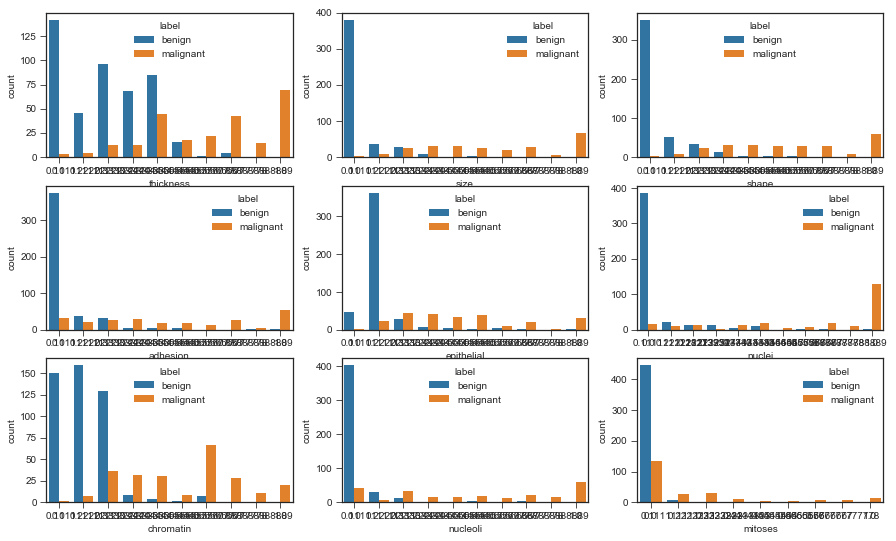

In [15]:
# The histogram plots for ALL numerical columns
fig,axes = plt.subplots(3,3, figsize = (15,9))
for i, t in enumerate(norm_list):
    sns.countplot(x =t, hue = "label", data= df, ax = axes[i//3, i%3]) 
    

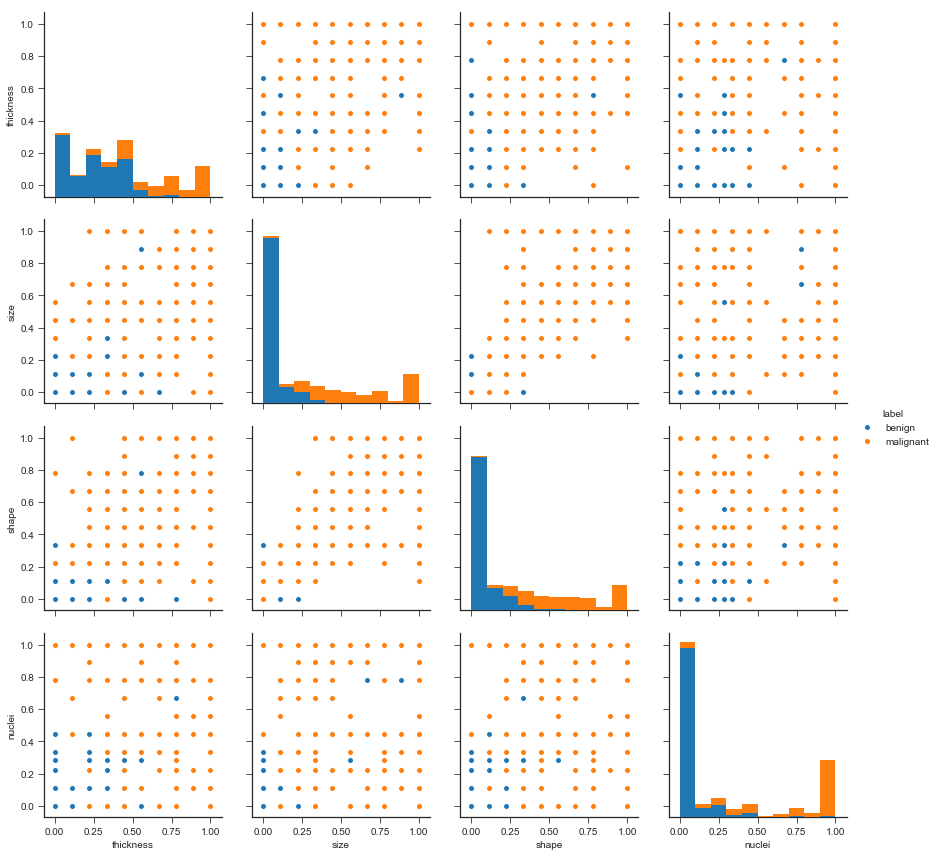

In [16]:
# I want to try wise pair plots to see the correlation 
list_check = ['thickness', 'size', 'shape','nuclei']
sns.pairplot(df, x_vars = list_check, y_vars = list_check,
             hue = 'label', size =3)

In [17]:
# Checking the correlation between different faetures
df.corr()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
thickness,1.000000,0.644913,0.654589,0.486356,0.521816,0.587300,0.558428,0.535835,0.350034,0.716001
size,0.644913,1.000000,0.906882,0.705582,0.751799,0.686801,0.755721,0.722865,0.458693,0.817904
shape,0.654589,0.906882,1.000000,0.683079,0.719668,0.709606,0.735948,0.719446,0.438911,0.818934
adhesion,0.486356,0.705582,0.683079,1.000000,0.599599,0.665049,0.666715,0.603352,0.417633,0.696800
epithelial,0.521816,0.751799,0.719668,0.599599,1.000000,0.581261,0.616102,0.628881,0.479101,0.682785
nuclei,0.587300,0.686801,0.709606,0.665049,0.581261,1.000000,0.675896,0.577362,0.338740,0.816050
chromatin,0.558428,0.755721,0.735948,0.666715,0.616102,0.675896,1.000000,0.665878,0.344169,0.756616
nucleoli,0.535835,0.722865,0.719446,0.603352,0.628881,0.577362,0.665878,1.000000,0.428336,0.712244
mitoses,0.350034,0.458693,0.438911,0.417633,0.479101,0.338740,0.344169,0.428336,1.000000,0.423170
status,0.716001,0.817904,0.818934,0.696800,0.682785,0.816050,0.756616,0.712244,0.423170,1.000000


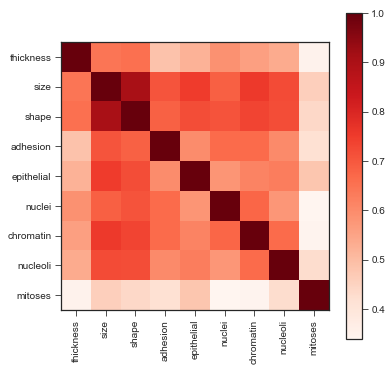

In [55]:
# using the imshow to plot the correlation matrix
plt.figure(figsize= (6,6))
plt.imshow(df[norm_list].corr(), cmap = plt.cm.Reds, interpolation = 'nearest')
plt.colorbar()

tick_marks = [i for i in range(len(df[norm_list].columns))]
plt.xticks(tick_marks, df[norm_list].columns, rotation = 'vertical')
plt.yticks(tick_marks, df[norm_list].columns)
plt.show()

We see the consistent information from box plots, histogram and correlations. All the feaures seem to have contribution to precdict the label, some of them such as 'thickness', 'chromaatin' they show the big different bewtween "benign" and "malignant" 

# Splitting data to Train and Test sets, ready for modeling


In [19]:
# setting label in to data frame y and data set to datafram x
y = df['status']
X = df.drop(["status", 'label'], axis = 1)

In [20]:
# sliting 50% of data to train set and 50% to the test set
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 7)

In [21]:
# Checking the balance of data  in Train and Test set
print("0: benign , 1: malignant")
print("For train data: ")
print(pd.value_counts(y_train, normalize = True))
print("For test data:  ")
print(pd.value_counts(y_test, normalize = True))

0: benign , 1: malignant
For train data: 
0.0    0.65043
1.0    0.34957
Name: status, dtype: float64
For test data:  
0.0    0.66
1.0    0.34
Name: status, dtype: float64


Using his quick check, we can see that this data set is not balance. But I will live with this way for now and deal with it later.

In [22]:
# try with linear_regression model 
linear = LogisticRegression()
linear.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
linear.score(x_test, y_test)

0.95428571428571429

In [24]:
y_linear = linear.predict(x_test)


In [25]:
confusion_matrix(y_test, y_linear)

array([[224,   7],
       [  9, 110]])

In [26]:
class_names = ['benign', 'malignant']
print(classification_report(y_test, y_linear, target_names = class_names))

             precision    recall  f1-score   support

     benign       0.96      0.97      0.97       231
  malignant       0.94      0.92      0.93       119

avg / total       0.95      0.95      0.95       350



In [27]:
# try randome forest 
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
rfc.score(x_test,y_test)

0.96571428571428575

In [29]:
y_rfc = rfc.predict(x_test)

In [30]:
confusion_matrix(y_test, y_rfc)

array([[224,   7],
       [  5, 114]])

In [31]:
print(classification_report(y_test, y_rfc, target_names = class_names))

             precision    recall  f1-score   support

     benign       0.98      0.97      0.97       231
  malignant       0.94      0.96      0.95       119

avg / total       0.97      0.97      0.97       350



# Model data using the Adaboosted classifier 

In [32]:
# Create the adaboost model and use the gridsearchCV to get the best parameters

ada_clf = AdaBoostClassifier()

param_grid ={
        'n_estimators': [100, 200,500],
        'learning_rate': [0.2,0.5,1.0],
},
grid_ada = GridSearchCV(ada_clf, cv=3, n_jobs=3, param_grid=param_grid)

grid_ada.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=3,
       param_grid=({'n_estimators': [100, 200, 500], 'learning_rate': [0.2, 0.5, 1.0]},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [33]:
# checking the best parameters from gridsearchCV for adaboosted classifier
grid_ada.best_params_

{'learning_rate': 0.2, 'n_estimators': 200}

In [34]:
# using the model above to do prediction on test data
y_ada = grid_ada.predict(x_test)

In [35]:
# Checking the accuracy of model 
print("The accurary of AdaBoosted Classification model: ", grid_ada.score(x_test, y_test))

The accurary of AdaBoosted Classification model:  0.96


In [36]:
# Checking the confusion Matrix
class_names = ['benign', 'malignant']
cnf_mat = confusion_matrix(y_test, y_ada)
cnf_mat

array([[223,   8],
       [  6, 113]])

In [37]:
# Function to do confusion matrix plot for better visualization 
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

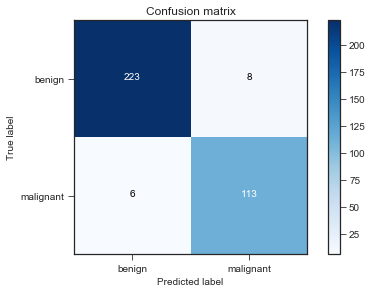

In [38]:
plot_confusion_matrix(cnf_mat, classes=class_names, title='Confusion matrix')

In [39]:
#Checking the summary of classifier performance
print(classification_report(y_test, y_ada, target_names = class_names))

             precision    recall  f1-score   support

     benign       0.97      0.97      0.97       231
  malignant       0.93      0.95      0.94       119

avg / total       0.96      0.96      0.96       350



In [40]:
# Checking the True postitive and Fall positive rate for ROC curver visualization
y_grid_ada_score = grid_ada.decision_function(x_test)
fpr_grid_ada, tpr_grid_ada, thresholds_grid_ada = roc_curve(y_test, y_grid_ada_score)

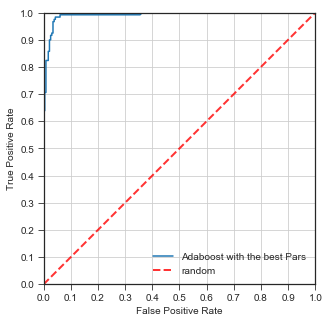

In [41]:
#plot the ROC curve  
plt.figure(figsize=(6,5))
plt.plot(fpr_grid_ada, tpr_grid_ada, label='Adaboost with the best Pars')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
plt.axes().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Using Isomap for reducing the features dimentions

In [42]:
# I will use isomap to compress data to 2 dimentions features
from sklearn.manifold import Isomap
iso = Isomap(n_neighbors = 5, n_components =2)
iso.fit(x_train)

Isomap(eigen_solver='auto', max_iter=None, n_components=2, n_jobs=1,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0)

In [43]:
x_train = iso.transform(x_train)
x_test = iso.transform(x_test)

print(" Shape of train data: ", x_train.shape)
print(" Shape of test data : ", x_test.shape)

 Shape of train data:  (349, 2)
 Shape of test data :  (350, 2)


# Model using the KNeighbors classifier

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors =5, weights = 'distance')
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [45]:
# .. your code changes above ..
knn.score(x_test, y_test)

0.96285714285714286

In [46]:
y_knn = knn.predict(x_test)

In [47]:
# Checking the confusion Matrix
cnf_mat_knn= confusion_matrix(y_test, y_knn)

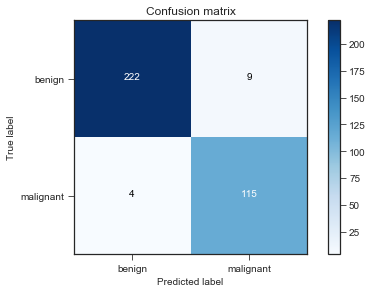

In [48]:
plot_confusion_matrix(cnf_mat_knn, classes=class_names, title='Confusion matrix')

In [49]:
#Checking the summary of classification
print(classification_report(y_test, y_knn, target_names = ['benign', 'malignant']))

             precision    recall  f1-score   support

     benign       0.98      0.96      0.97       231
  malignant       0.93      0.97      0.95       119

avg / total       0.96      0.96      0.96       350



In [50]:
# plot the boundary condition for knn
def plotDecisionBoundary(model, X, y):
    print("Color: Blue: benign")
    print('Salmom: maglinant')
    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.1
    resolution = 0.1

    #(0 for benign, 1 for malignant)
    colors = {0:'royalblue', 1:'lightsalmon'} 


    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Create a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # What class does the classifier say?
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour map
    plt.contourf(xx, yy, Z, cmap=plt.cm.seismic)
    plt.axis('tight')

    #Plot your testing points as well...
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

    p = model.get_params()
    plt.title('K = ' + str(p['n_neighbors']))
    plt.show()

Color: Blue: benign
Salmom: maglinant


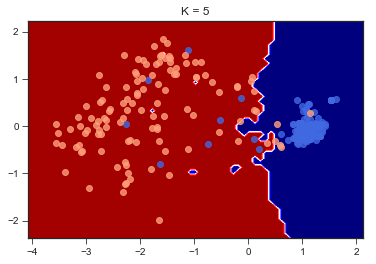

In [51]:
plotDecisionBoundary(knn, x_test, y_test)

# Summary
- With this data set we be able to build a model to predict the status of patient either benign or malignant up to the accuarcy level 96%. 
- We noticed that this data set is imbalance, number of bengin sample is about two times more than malignant. With this situation the accuracy is not the best way to judge the performance of model. It is more relavant to look at the presision, recall and confusion matrix. For this problem we need to care about both False Postivie and False Negative:
    - False Positive: Mean that the patient is being benign but predicted as malignant. This will make doctor required further test, treatment, ect. This error would be wasteful in term of resources but not patient life.
    - False Negative: Mean that the patient is being malignant but predicted as benign. For this error dotor will not pay enough attention and have early treatmeant for patient. This will give time for tumor to progess to more serious stages and more dangerous patient life.
- Looking at two Machine Learning algorithm I used in this project. The accuarcy of both Adaboost and KNeighbor are almost the same. But I can see that for Kneighbors the False Negative is better it corresponding to the recall of "malignant" increases from 95% (Adaboost) to 97% (Kneighbors). It means that more malignant status are predicted correcly. 

- The model performance is reasonably well. But I think we still have room to improve it. I want to:
    - Try other algorithms to see if any other gives better performmanace.
    - Deal with the imbalance in data can help improvement of the model
    - Tune parameters a bit more to optimize the performance 